In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.linear_model import Ridge 

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r0krsflq because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
dataset_name = 'chewie_10_07'
PATH = 'f"/disk/scratch2/nkudryas/BAND-torch/datasets'
best_model_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-torch-example/{dataset_name}/"

model_titles = ["LFADS", "BAND"]

bin_size_ms = 10

In [78]:
# model_names = ['231203_1324_exampleSingle','231203_1322_exampleSingle'] # KL=0
model_names = ['231203_142531_exampleSingle','231203_142544_exampleSingle'] #  KL=1, but mean log-lik (should be sum)
# model_names = ['231203_153455_exampleSingle','231203_153446_exampleSingle'] # KL=1, sum log-lik
model_dests = [f"{best_model_dest}/{model_name}" for model_name in model_names]
# models = [BAND(model_dir=model_dest) for model_dest in model_dests]

In [79]:
# from pathlib import Path


# filename = Path(filename)
# # Set up the dataloaders
# datamodule.setup()
# pred_dls = datamodule.predict_dataloader()
# # Set the model to evaluation mode
# model.eval()

# Run on test

In [80]:
dataset_filename = '/disk/scratch2/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_M1_spikes_go.h5'

with h5py.File(dataset_filename, 'r') as f:
    train_data = f['train_recon_data'][:]
    valid_data = f['valid_recon_data'][:]
    train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
    true_train_beh = f['train_vel'][:]
    true_valid_beh = f['valid_vel'][:]

In [81]:
def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
    n_samples = len(train_data) + len(valid_data)
    merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
    merged_data[train_inds] = train_data
    merged_data[valid_inds] = valid_data
    return merged_data

# Get the paths to all data files
both_factors = []
both_rates = []
both_behaviors = []
lin_decoded_behs = []
seq2seq_decoded_behs = []
control_decoded_behs = []
for model_name in model_names:
    data_path = best_model_dest + model_name + '/lfads_output_sess0.h5'
    bin_width_sec = 0.01 # chewie
    # Data is binned at 10 ms
    with h5py.File(data_path) as f:
        # print(f.keys())
        # Merge train and valid data for factors and rates
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        factors = f["valid_factors"][:]
        rates = f["valid_output_params"][:] / bin_width_sec
        behavior = f["valid_output_behavior_params"][:]
        controls = f['valid_gen_inputs'][:]

        train_factors = f["train_factors"][:]
        train_controls = f['train_gen_inputs'][:]
    
    # train Ridge regression to predict behavior from factors (0lag)
    X_train = train_factors.reshape(-1,train_factors.shape[-1])
    Y_train = true_train_beh.reshape(-1,true_train_beh.shape[-1])
    X_test = factors.reshape(-1,factors.shape[-1])
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_0lag = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge seq2seq
    X_train = train_factors.reshape(train_factors.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = factors.reshape(factors.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge from control inputs (seq2seq)
    X_train = train_controls.reshape(train_controls.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = controls.reshape(controls.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_control = ridge.predict(X_test).reshape(true_valid_beh.shape)
            
    both_factors.append(factors)
    both_rates.append(rates)
    both_behaviors.append(behavior)
    lin_decoded_behs.append(Y_pred_0lag)
    seq2seq_decoded_behs.append(Y_pred_seq2seq)
    control_decoded_behs.append(Y_pred_control)

In [82]:
factors.shape

(116, 101, 40)

In [83]:
def R2(pred_beh,true_beh):
    return (1 - np.sum((pred_beh - true_beh)**2) / np.sum((true_beh - np.mean(true_beh))**2)) * 100

In [84]:
# p_train.gen_inputs.shape
both_behaviors[0].shape, true_valid_beh.shape

((116, 101, 2), (116, 101, 2))

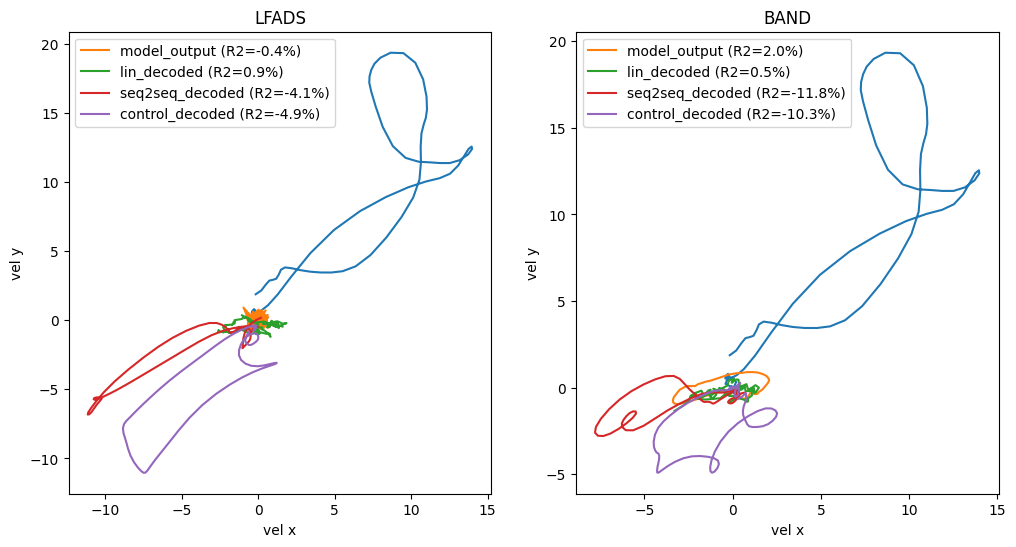

In [85]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
trial_id = 1
axes[0].plot(*true_valid_beh[trial_id].T)
axes[1].plot(*true_valid_beh[trial_id].T)
for i in range(len(both_behaviors)):
    axes[i].plot(*both_behaviors[i][trial_id].T, label=f'model_output (R2={R2(both_behaviors[i],true_valid_beh):.1f}%)')
    axes[i].plot(*lin_decoded_behs[i][trial_id].T, label=f'lin_decoded (R2={R2(lin_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].plot(*seq2seq_decoded_behs[i][trial_id].T, label=f'seq2seq_decoded (R2={R2(seq2seq_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].plot(*control_decoded_behs[i][trial_id].T, label=f'control_decoded (R2={R2(control_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].set_xlabel('vel x')
    axes[i].set_ylabel('vel y')
    axes[i].set_title(model_titles[i])
    axes[i].legend()


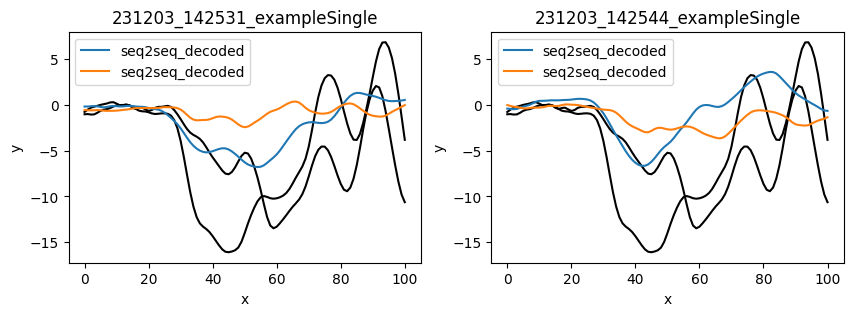

In [86]:
for trial_id in [13]:
    fig,axes = plt.subplots(1,2, figsize=(10,3))
    axes[0].plot(true_valid_beh[trial_id],c='k')
    axes[1].plot(true_valid_beh[trial_id],c='k')
    for i in range(len(lin_decoded_behs)):
        # if i==1:
        # axes[i].plot(model_output_behs[i][trial_id], label='model_output')
        # axes[i].plot(lin_decoded_behs[i][trial_id], label='lin_decoded')
        axes[i].plot(seq2seq_decoded_behs[i][trial_id], label='seq2seq_decoded')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].set_title(model_names[i])
        axes[i].legend()

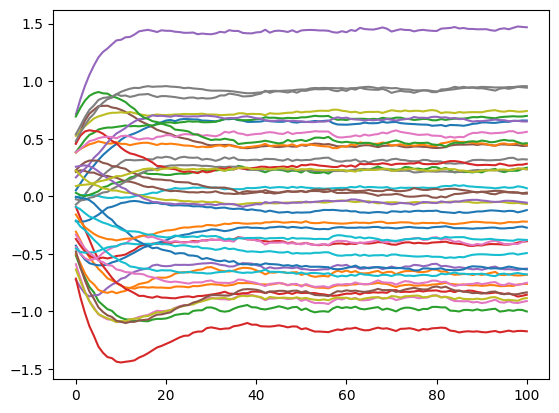

In [88]:
plt.plot(factors[0]);